# Matching

In [1]:
import math
import os
import sys

sys.path.insert(0, os.path.abspath('/data/autocnet'))

import autocnet
from autocnet import CandidateGraph

# The GPU based extraction library that contains SIFT extraction and matching
import cudasift as cs

# A method to resize the images on the fly.
from scipy.misc import imresize

%pylab inline
figsize(16,4)

Populating the interactive namespace from numpy and matplotlib


## CandidateGraph -> Custom Extraction Func -> Matching

In [8]:
a = 'AS15-P-0111_CENTER_LRG_CROPPED.png'
b = 'AS15-P-0112_CENTER_LRG_CROPPED.png'

adj = {a:[b],
       b:[a]}

cg = CandidateGraph.from_adjacency(adj)

# Enable the GPU
autocnet.cuda(enable=True, gpu=0)

# Write a custom keypoint extraction function - this could get monkey patched onto the graph object...
def extract(arr, downsample_amount=None, **kwargs):
    total_size = arr.shape[0] * arr.shape[1]
    if not downsample_amount:
        downsample_amount = math.ceil(total_size / 12500**2)
    shape = (int(arr.shape[0] / downsample_amount), int(arr.shape[1] / downsample_amount))
    # Downsample
    arr = imresize(arr, shape, interp='lanczos')
    
    npts = max(arr0.shape) / 3.5
    sd = cs.PySiftData(npts)
    cs.ExtractKeypoints(arr, sd, **kwargs)
    kp, des = sd.to_data_frame()
    kp = kp[['x', 'y', 'scale', 'sharpness', 'edgeness', 'orientation', 'score', 'ambiguity']]
    kp['score'] = 0.0
    kp['ambiguity'] = 0.0
    
    return kp, des, sd, downsample_amount, arr

arr0 = cg.node[0].geodata.read_array()
kp0, des0, sd0, downsample_amount0, arr0 = extract(arr0, thresh=1)

arr1 = cg.node[1].geodata.read_array()
kp1, des1, sd1, downsample_amount1, arr1 = extract(arr1, thresh=1)


In [9]:
# How much downsampling?
downsample_amount0, downsample_amount1

(5, 5)

Now that the keypoints have been extracted it is time to apply the GPU based matcher.  Since this is working with the lower level API, the correspondences are read from the GPU and then piped back.  This is technical inefficient, but fast enough that saving a few lines of code managing GPU memory is worth it.

In [10]:
sd0 = cs.PySiftData.from_data_frame(kp0, des0)
sd1 = cs.PySiftData.from_data_frame(kp1, des1)
# Apply the matcher
cs.PyMatchSiftData(sd0, sd1)

## The matches DataFrame

Matches are stored as [Pandas DataFrames](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) meaning that all functionality available to a Pandas DataFrame is available to the matches.  This includes:

- Visualization
- Sorting
- SQL style queries
- Split-Apply-Combine Operations
- Statistical Analysis

In [11]:
matches, _ = sd0.to_data_frame()
matches.head(3)

,x,y,scale,sharpness,edgeness,orientation,score,ambiguity,match,match_xpos,match_ypos,match_error,subsampling
0,9528.347656,195.259979,20.769804,3.171909,4.874205,191.425842,0.952312,0.998823,1969,7409.627930,464.366821,0.0,0.0
1,4080.437012,66.662041,16.442673,-1.066230,5.038958,272.796051,0.978477,0.999569,351,7551.666992,42.322033,0.0,0.0
2,5775.711914,140.684418,21.859934,2.915606,4.006656,247.030746,0.936110,0.949781,21,3847.362793,140.941910,0.0,0.0


## Position, Ambiguity, and Score
Three important pieces of information in the matches dataframe are the x/y position of correspondences, the ambiguity, and the score.

**Position**: The position of the correspondence in arr0 (assuming matches points to sd0) is the `x` and `y` position.  The correspondence position in the other image is defined by `match_xpos` and `match_ypos`.

**Ambiguity**: Ambiguity is a measure of Lowe's ratio test that compares the 'likeness' of correspondences.  In brief, during matching the top two matches are found.  Meaning correspondence 0 in the source image is matched to 2 candidate correspondences in the other image.  The quality of these matches is defined as the distance between two 128 element vectors (the descriptors).  Ambiguity is a measure of the ratio of the second distance to the first distance.  The closer this value is to 1, the more ambiguous the correspondence.  The lower the ambiguity the better.  Lowe suggests 0.8 as a threshold, but this is too constraining for highly homogeneous planetary data.

**Score**: Score is a measure of the quality of the match scaled to the range [0,1] from the inital, unknown range of Euclidean distances.  The higher the score the better.

count    17062.000000
mean         0.991214
std          0.010747
min          0.789020
25%          0.988632
50%          0.994540
75%          0.997817
max          0.999998
Name: ambiguity, dtype: float64

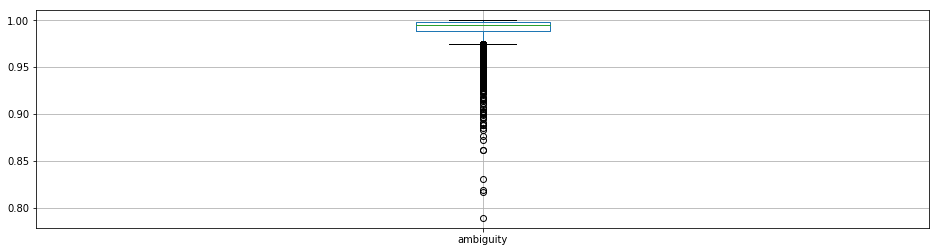

In [12]:
# Box plot and descriptive stats for the distribution of ambiguities
matches.boxplot('ambiguity')
matches['ambiguity'].describe()

Clearly, Lowe's suggested 0.8 ratio is going to remove almost all of the data.  The 0.95 threshold looks attractive as it is below the lower quartile break.

In [13]:
ksub = matches[matches.ambiguity <= 0.95]

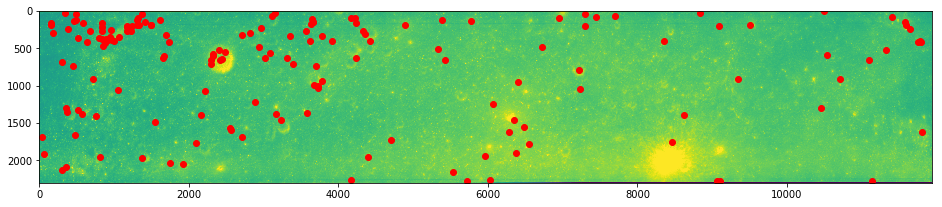

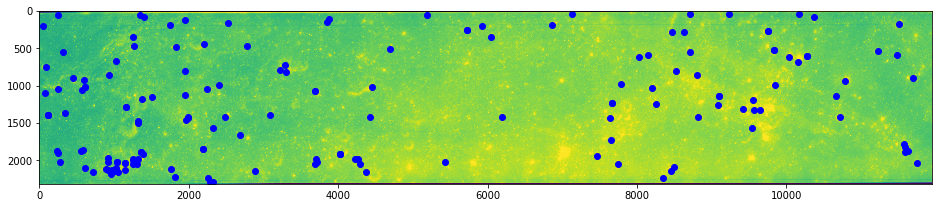

In [14]:
# And plot
imshow(arr0)
plot(ksub.x, ksub.y, 'ro')
show()
imshow(arr1)
plot(ksub.match_xpos, ksub.match_ypos, 'bo')
show()

### Score

count    163.000000
mean       0.898343
std        0.048708
min        0.775125
25%        0.866216
50%        0.897366
75%        0.929772
max        0.989991
Name: score, dtype: float64

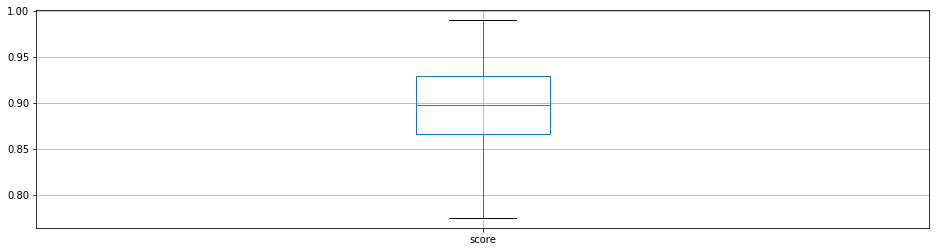

In [16]:
ksub.boxplot(column='score')
ksub.score.describe()

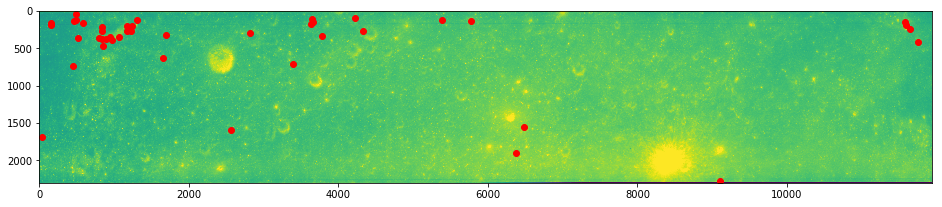

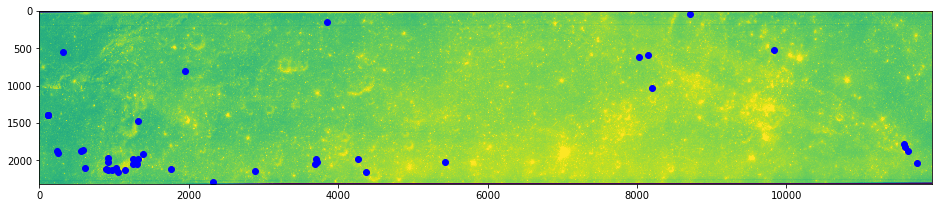

In [17]:
kss = ksub[ksub.score >= 0.925310]
imshow(arr0)
plot(kss.x, kss.y, 'ro')
show()
imshow(arr1)
plot(kss.match_xpos, kss.match_ypos, 'bo')
show()

The combined reduction due to `ambiguity` and `score` winnowing has generated what looks like a relatively good starting point for more robust outlier detection methods.